# Guillaume Payeur (260929164)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({"text.usetex": True})

# Q1

I start by writting a function to do an RK4 step.

In [3]:
def rk4_step(fun,x,y,h):
    k1 = fun(x,y)
    k2 = fun(x+h/2,y+h*k1/2)
    k3 = fun(x+h/2,y+h*k2/2)
    k4 = fun(x+h,y+h*k3)
    return x+h,y+(1/6)*(k1+2*k2+2*k3+k4)*h

Now I integrate 
\begin{align}
    \frac{dy}{dx}=\frac{y}{1+x^2}
\end{align}
from $x=-20$ to $x=20$ with $y(-20)=1$ using $200$ steps.

In [4]:
# Number of steps
n_steps = 200

# arrays to hold solution
x = -20*np.ones((n_steps+1))
y = np.ones((n_steps+1))
h = (20-(-20))/n_steps

def fun(x,y):
    return y/(1+x**2)

for i in range(n_steps+1):
    if i!=0:
        x[i],y[i] = rk4_step(fun,x[i-1],y[i-1],h)

and now I plot the result, and compare with the analytic solution to make sure it worked.

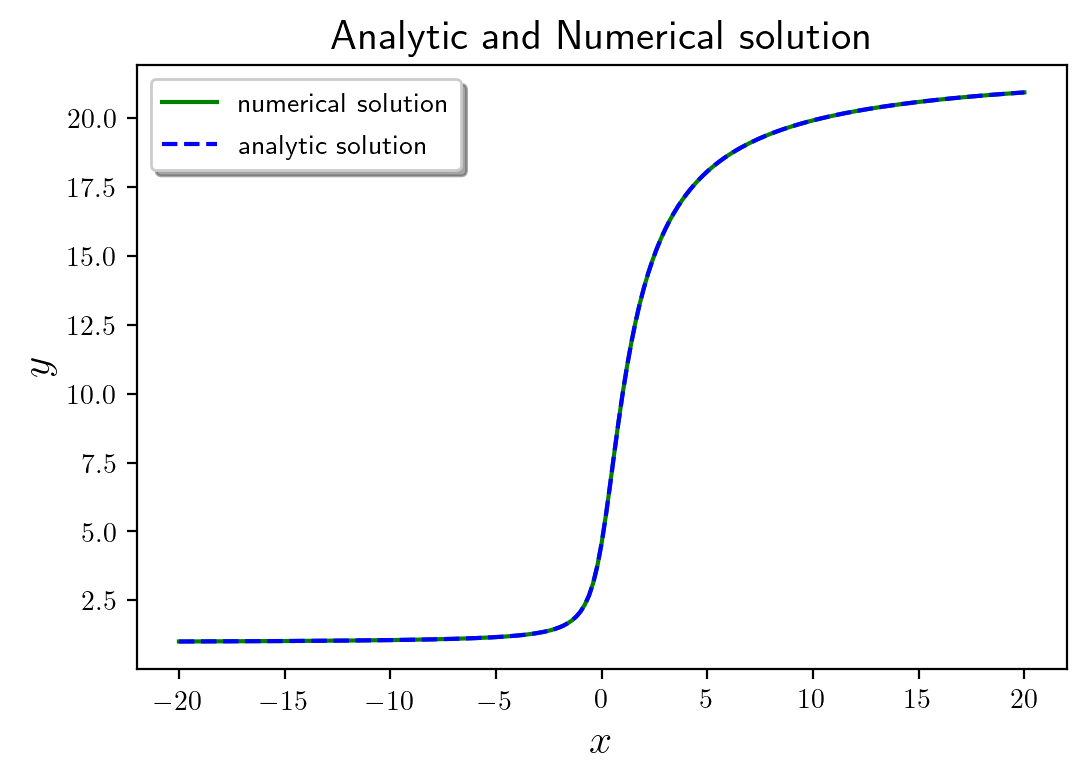

In [5]:
plt.plot(x,y,color='green',label='numerical solution')
plt.plot(x,np.exp(np.arctan(x))/np.exp(np.arctan(-20)),color='blue',label='analytic solution',ls='--')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$y$',fontsize=15)
plt.title('Analytic and Numerical solution',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

Text(0.5, 1.0, 'Error on Numerical Solution')

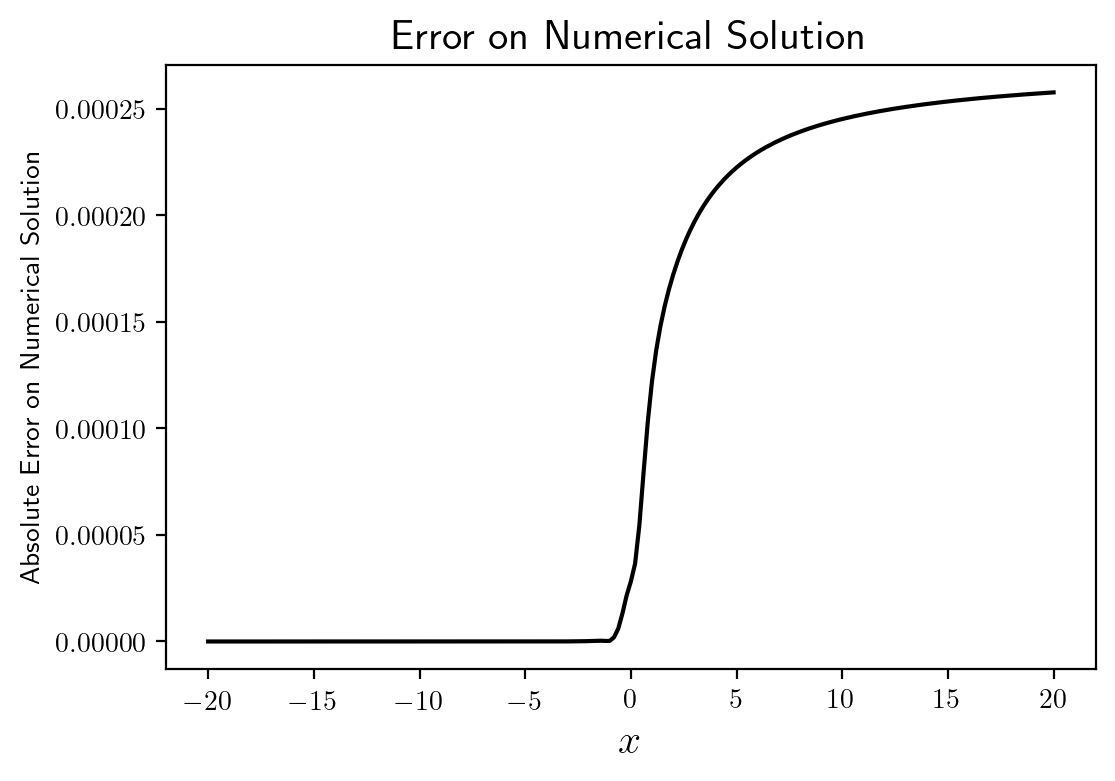

In [6]:
plt.plot(x,np.abs(y-np.exp(np.arctan(x))/np.exp(np.arctan(-20))),color='black')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('Absolute Error on Numerical Solution',fontsize=10)
plt.title('Error on Numerical Solution',fontsize=15)

The error grows with x as espected but it stays reasonably small especially given we did only 200 steps.

Now we split each step of length $h$ into two steps of length $h/2$. Refer to the $y$ value after a step of size $h$ and two  steps of $h/2$ as $y_1$ and $y_2$, respectively. Because in RK4 the total error scales with $h^4$, we immediately know that the combination we need to take is
\begin{align}
    y = \frac{y_1-2^4y_2}{1-2^4}
\end{align}
and that's what I do below.

In [7]:
# rk4 steps where we combine steps of size h and h/2
def rk4_stepd(fun,x,y,h):
    # one step
    x_1step,y_1step=rk4_step(fun,x,y,h) # 4 calls
    
    # two steps
    x_2step,y_2step=rk4_step(fun,x,y,h/2) # 4 calls
    x_2step,y_2step=rk4_step(fun,x_2step,y_2step,h/2) # 4 calls

    # taking the appropriate combination of the two results
    x = x_1step
    y = (y_1step-2**4*y_2step)/(1-2**4)
    return x,y

This method of also splitting the step into two smaller steps means we make three times as many function evaluations, because we call rk4_step written previously three times per step, instead of just once. Below I solve the same equation for a fixed number of function calls $(1200)$ for both methods.

In [8]:
# number of function calls
n_calls = 12*100

# arrays to hold solution where we use steps of size h
x_1step = -20*np.ones((int(n_calls/4))+1)
y_1step = np.ones((int(n_calls/4))+1)
h_1step = (20-(-20))/(n_calls/4)

# arrays to hold the solution where we combine steps of size h and h/2
x_2step = -20*np.ones((int(n_calls/12))+1)
y_2step = np.ones((int(n_calls/12))+1)
h_2step = (20-(-20))/(n_calls/12)

# function to integrate
def fun(x,y):
    return y/(1+x**2)

# solving numerically with steps of size h
for i in range(int(n_calls/4)+1):
    if i!=0:
        x_1step[i],y_1step[i] = rk4_step(fun,x_1step[i-1],y_1step[i-1],h_1step)
# solving numerically combining steps of size h and h/2
for i in range(int(n_calls/12)+1):
    if i!=0:
        x_2step[i],y_2step[i] = rk4_stepd(fun,x_2step[i-1],y_2step[i-1],h_2step)

Now I plot the numerical solution obtained previously (green) and the numerical solution obtained with the new split steps technique (red). I also plot the absolute error on both solutions.

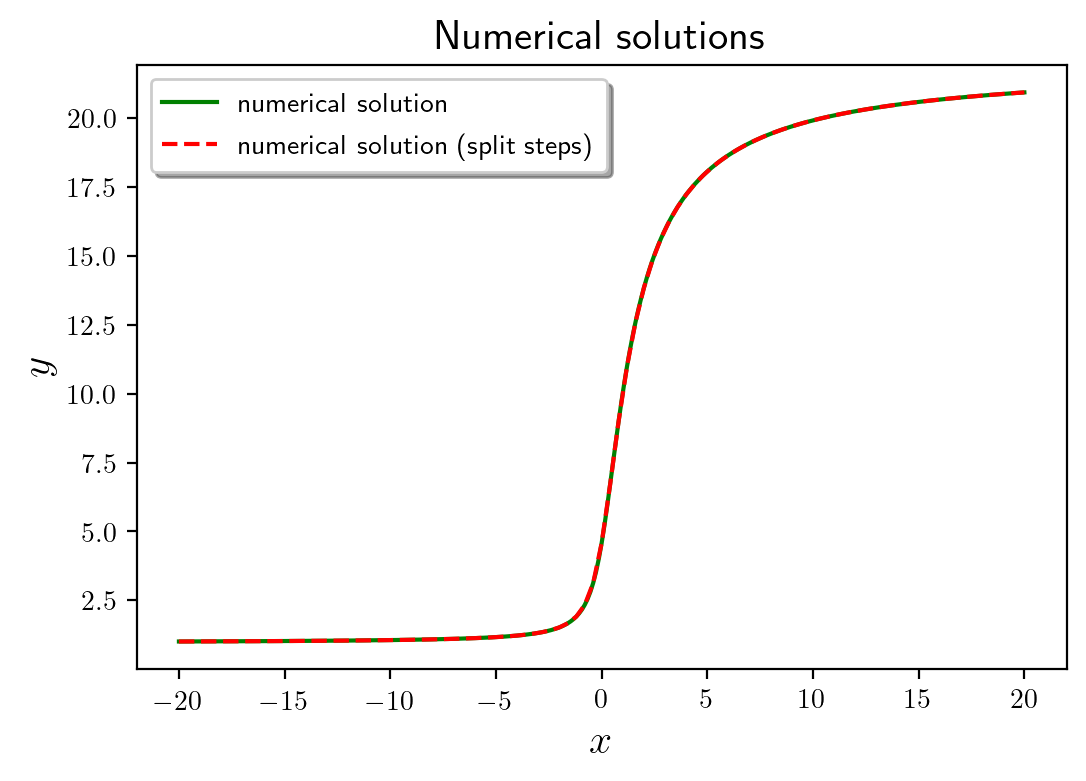

In [9]:
plt.plot(x_1step,y_1step,color='green',label='numerical solution')
plt.plot(x_2step,y_2step,color='red',label='numerical solution (split steps)',ls='--')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$y$',fontsize=15)
plt.title('Numerical solutions',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

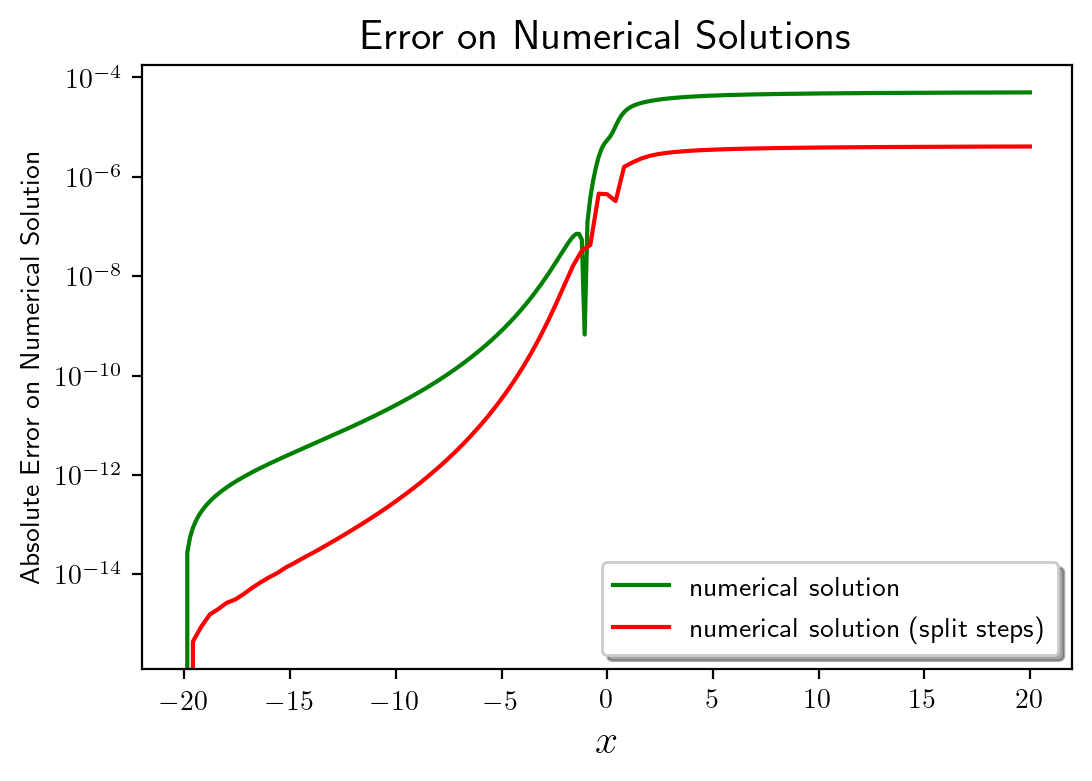

In [10]:
plt.plot(x_1step,np.abs(y_1step-np.exp(np.arctan(x_1step))/np.exp(np.arctan(-20))),color='green',label='numerical solution')
plt.plot(x_2step,np.abs(y_2step-np.exp(np.arctan(x_2step))/np.exp(np.arctan(-20))),color='red',label='numerical solution (split steps)')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('Absolute Error on Numerical Solution',fontsize=10)
plt.title('Error on Numerical Solutions',fontsize=15)
plt.yscale('log')
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

So in this case the more accurate solution for the same number of function evaluations is the one where we split each step into two. The difference looks small because this is a log scale but actually the error is reduced by a factor of ~$10$.

# Q2

We solve for the evolution of all decay products using Scipy' solve_ivp, and using the method "Radau", since we are dealing with a very stiff system.

In [11]:
# Making array of half lives
year = 365*24*60*60
day = 24*60*60
hour = 60*60
minute = 60
second = 1
half_life = np.array([4468*1e9*year,
                      24.1*day,
                      6.7*hour,
                      245500*year,
                      75380*year,
                      1600*year,
                      3.8235*day,
                      3.1*minute,
                      26.8*minute,
                      19.9*minute,
                      164.3*1e-3*second,
                      22.3*year,
                      5015*year,
                      138.376*day])

# Normalizing half lives so that the normalized half life of U238 is 1
half_life_0 = half_life[0]
half_life=half_life/half_life_0

# Derivative dy/dt
def fun(t,y):
    dydt = np.zeros((half_life.shape[0]+1))
    for i in range(dydt.shape[0]):
        if i==0:
            dydt[i]=-y[i]/half_life[i]
        elif i==dydt.shape[0]-1:
            dydt[i]=y[i-1]/half_life[i-1]
        else:
            dydt[i]=-y[i]/half_life[i]+y[i-1]/half_life[i-1]
    return dydt

In [12]:
# Setting initial conditions to contain only U238
y0 = np.zeros((half_life.shape[0]+1))
y0[0] = 1

# Solving the ODE
sol = solve_ivp(fun,[0,1],y0,method='Radau',rtol=2.22e-14,atol=1e-14)

C:\Users\Guill\Anaconda3\envs\ml\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


Approximating the decay of all species other than U238 to Pb206 to be instant, we get that the analytic solution for U238 and Pb206 should be
\begin{align}
    \text{U238} &= e^{-t}\\
    \text{Pb206} &= 1-e^{-t}
\end{align}
so their ratio should be
\begin{align}
    \text{Pb206/U238} = \frac{1-e^{-t}}{e^{-t}}
\end{align}
Below I plot this ratio as obtained numerically and analytically. I use time units of half lives of U238.

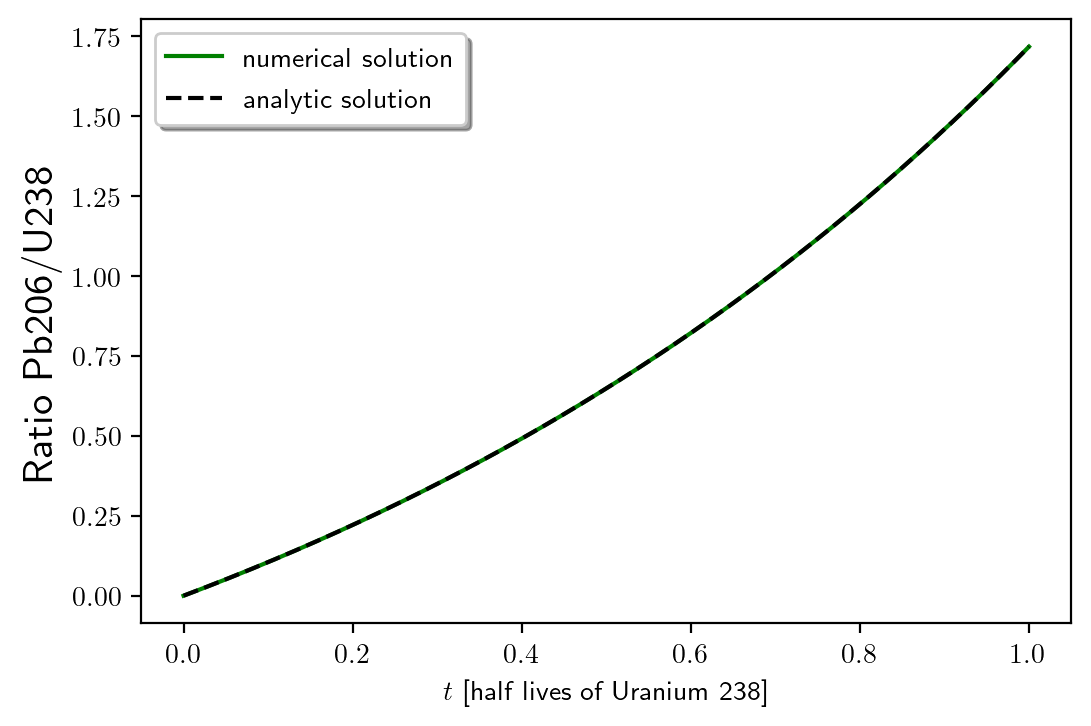

In [13]:
plt.plot(sol.t,sol.y[-1]/sol.y[0],color='green',label='numerical solution')
plt.plot(sol.t,(1-np.exp(-sol.t))/np.exp(-sol.t),color='black',ls='--',label='analytic solution')
plt.xlabel('$t$ [half lives of Uranium 238]')
plt.ylabel('Ratio Pb206/U238',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

Both solutions match. Now I plot the ratio Th230/U234 as obtained numerically. I use time units of half lives of T230

C:\Users\Guill\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Ratio of Th230 to U234 Versus Time')

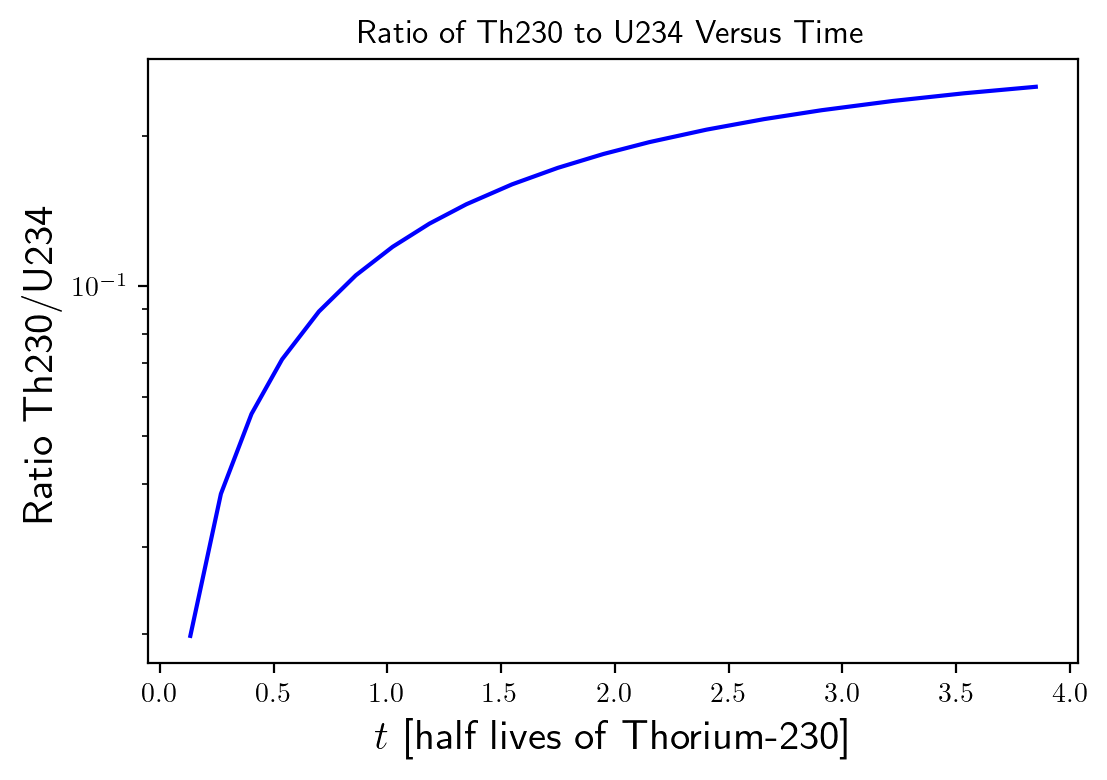

In [14]:
plt.plot(sol.t[0:20]/half_life[4],(sol.y[4]/sol.y[3])[0:20],color='blue')
plt.yscale('log')
plt.xlabel('$t$ [half lives of Thorium-230]',fontsize=15)
plt.ylabel('Ratio Th230/U234',fontsize=15)
plt.title('Ratio of Th230 to U234 Versus Time')

This would be useful to do dating on times of the order of a half life of Thorium-230 which is 75380 years.

# Q3

Rewrite the relation
\begin{align}
    z-z_0 = a((x-x_0)^2+(y-y_0)^2)
\end{align}
as 
\begin{align}
    z &= (z_0+ax_0^2+ay_0^2)+ax^2+ay^2-2ax_0x-2ay_0y\\
    &= c_0 + c_1(x^2+y^2) + c_2x + c_3y
\end{align}
where
\begin{align}
    c_0 &= z_0+a(x_0^2+y_0^2)\\
    c_1 &= a\\
    c_2 &= -2ax_0\\
    c_3 &= -2ay_0
\end{align}
Then finding the best fit parameters $c_0$ to $c_3$ assuming Gaussian errors is a linear least squares problem. I start by plotting the raw data.

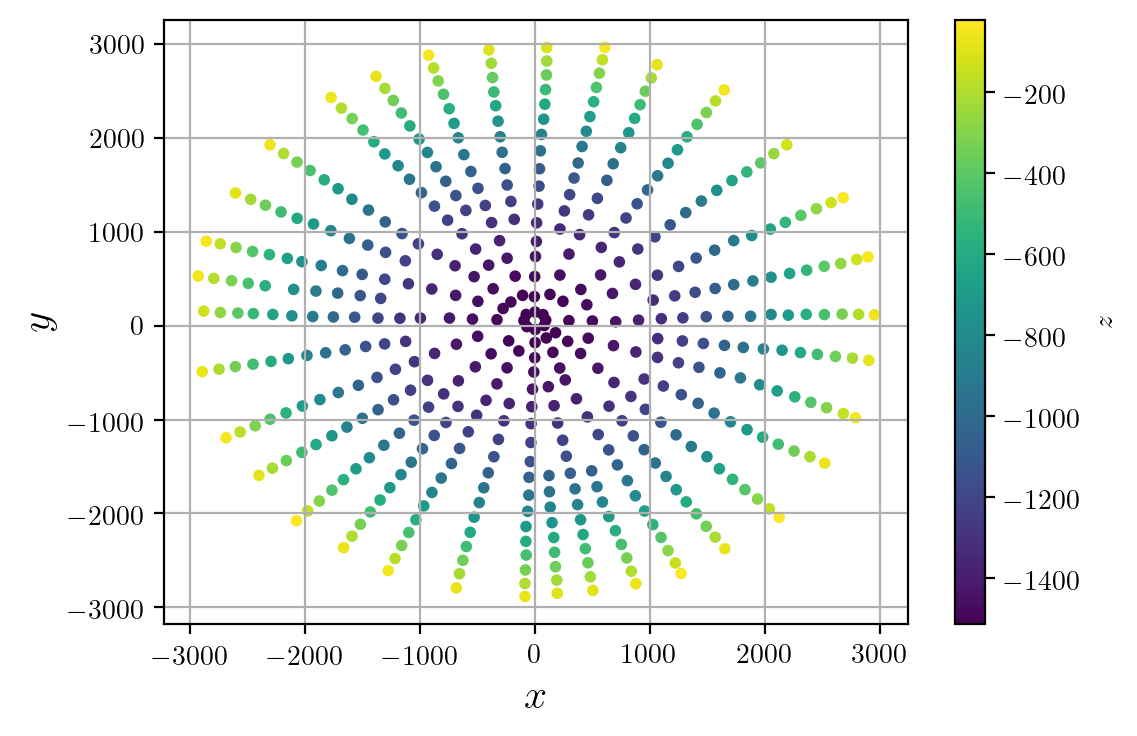

In [15]:
# Plotting the raw data
dat=np.loadtxt('dish_zenith.txt')
x = dat[:,0]
y = dat[:,1]
z = dat[:,2]

plt.scatter(x,y,s=10,c=z)
cbar = plt.colorbar(label='$z$')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$y$',fontsize=15)
plt.grid()

Now I do the linear least squares fit for $c_0$ to $c_3$ as we learned it in class

In [16]:
# number of data points
n_pts = x.shape[0]

# Creating matrices A and X
A = np.zeros((n_pts,4))
A[:,0] = 1
A[:,1] = x**2+y**2
A[:,2] = x
A[:,3] = y
X = z

# obtaining least square parameters as vector m
m = np.linalg.inv(A.T@A)@A.T@X

# print the parameters
print('c_0:',m[0])
print('c_1:',m[1])
print('c_2:',m[2])
print('c_3:',m[3])

# Converting back to a,x0,y0,z0
a = m[1]
x0 = m[2]/(-2*a)
y0 = m[3]/(-2*a)
z0 = m[0]-a*(x0**2+y0**2)

# print the parameters
print('a:',a)
print('x0:',x0)
print('y0:',y0)
print('z0:',z0)

# Calculating the focal length and printing it in meters
f = 1/(4*a)
f_meters = f*1e-3
print('f in meters:',f_meters)

c_0: -1512.3118166739055
c_1: 0.0001667044547740131
c_2: 0.0004535990279794749
c_3: -0.019411558852636002
a: 0.0001667044547740131
x0: -1.3604886221978296
y0: 58.22147608157978
z0: -1512.8772100367862
f in meters: 1.4996599841252205


So we see that the best fit parameters are
\begin{align}
    c_0 &= -1.51\text{x}10^3 \text{ mm}\\
    c_1 &= 1.67\text{x}10^{-4} \text{ mm}^{-1}\\
    c_2 &= 4.54\text{x}10^{-4}\\
    c_3 &= -1.94\text{x}10^{-2}
\end{align}
or equivalently
\begin{align}
    a &= 1.67\text{x}10^{-4} \text{ mm}^{-1}\\
    x_0 &= -1.36 \text{ mm}\\
    y_0 &= 58.2 \text{ mm}\\
    z_0 &= -1512 \text{ mm}\\
\end{align}

Now, we can compute the focal length via
\begin{align}
    f = \frac{1}{4a}
\end{align}
As for the error on $a$, we first estimate the error in the data. We do that by assuming constant gaussian errors on all points, and tuning the size of this gaussian error so that our data has a reduced $\chi_2$ of $1$ under the model constisting of the best fit parameters above.

In [17]:
# first, assuming all errors = 1mm
sigma = 1
dof = n_pts-4
chi2_reduced = np.sum((z - A@m)**2/(sigma**2))/dof

# adjusting errors to get chi2 = 1
sigma = np.sqrt(chi2_reduced)
chi2_reduced = np.sum((z - A@m)**2/(sigma**2))/dof

# checking that now, chi2_reduced = 1
print(chi2_reduced)

# getting the size of errors
print(sigma)

0.9999999999999999
3.784306256953966


So this gives that the uncertainty in each of the x,y,z coordinates measurements is ~$3.78$ mm.

Now we compute the covariance matrix for $c_0$ to $c_3$ as
\begin{align}
   \text{Cov} = (A^TN^{-1}A)^{-1}
\end{align}
where N is a diagonal matrix with $\sigma^2$ everywhere on the diagonal. The uncertainty on $a$ is then $(\text{Cov}_{11})^{1/2}$.

In [18]:
cov = np.linalg.inv((1/sigma**2)*A.T@A)
e_a = np.sqrt(np.diag(cov))[1]
print(e_a)

6.479238438011916e-08


So now we have a value for $a$ and it's uncertainty. The uncertainty is $6.5\text{x}10^{-8}$ mm$^{-1}$. Now we propagate this error to $f$ via a first order taylor polynomial approximation, which we can do since the error on $a$ is small in comparison to $a$.
\begin{align}
    f&=\frac{1}{4a}\\
    \implies \Delta f &\approx \frac{-1}{4a^2}\Delta a\\
    \implies |\Delta f| &\approx \frac{1}{4a^2}|\Delta a|
\end{align}
Below I calculate the error on $f$ using that

In [19]:
# propagating error on a to f
e_f = 1/(4*a**2)*e_a

# prining f in meters
f_meters = f*1e-3
e_f_meters = e_f*1e-3
print(f_meters,e_f_meters)

1.4996599841252205 0.00058286712411282


So our result is
\begin{align}
    \boxed{f = (1.4996\pm0.0006) \text{ m}}
\end{align}
which is in agreement with the true value of 1.5 m.